In [1]:
# # libraries installed additionally include

# !conda install -c simpleitk simpleitk
# !pip install imageio

# # requirements:
# import nibabel as nib
# import numpy as np
import SimpleITK as sitk
# import nilearn
# import shutil
# import glob
# import matplotlib.pylab as plt
# import imageio
# import datetime
# import numpy as np
# import scipy
# from scipy import ndimage

In [2]:
import os
import pathlib as plb
# import GIF_mip as mip
import nibabel as nib
import numpy as np
import scipy
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob


In [3]:
import PIL
from PIL import Image
from skimage.transform import rotate
import time

import pandas as pd

In [4]:
# nii_root = plb.Path('/media/storage/Joy/datasets/NIFTI/FDG-PET-CT-Lesions/')
nii_root = plb.Path('/gpfs/fs0/data/stanford_data/petct/NIFTI_MIP/FDG-PET-CT-Lesions/')
!ls $nii_root

PETCT_0011f3deaf  PETCT_43323b7d42  PETCT_816732638d  PETCT_c2ffda4725
PETCT_01140d52d8  PETCT_43647ff727  PETCT_81debf13a1  PETCT_c32e1daf9b
PETCT_0117d7f11f  PETCT_437d2c96fe  PETCT_82137245b0  PETCT_c38b168f1a
PETCT_0143bab87a  PETCT_43c9c71b31  PETCT_824c6a0014  PETCT_c395306306
PETCT_01682f60c3  PETCT_4404466919  PETCT_8311aeddb9  PETCT_c3cc732d95
PETCT_0168f65af8  PETCT_442a09f90e  PETCT_83e4c5b578  PETCT_c4a686881e
PETCT_0223010e46  PETCT_4481687483  PETCT_846c1af245  PETCT_c517c47bed
PETCT_0225325b91  PETCT_448225c237  PETCT_84e7715ed9  PETCT_c58477f3b4
PETCT_02ba7e20f5  PETCT_44b08f570e  PETCT_855c7fca12  PETCT_c58b637e17
PETCT_0410759456  PETCT_44b95650c3  PETCT_85b69fed1c  PETCT_c596a50286
PETCT_04606080a0  PETCT_44bf7dc508  PETCT_86153b2974  PETCT_c5a143a604
PETCT_048981112f  PETCT_44c04dcf65  PETCT_86e54ea60a  PETCT_c6730783de
PETCT_04a4e1c874  PETCT_44cfacfd6e  PETCT_870181d7fd  PETCT_c73c2685c0
PETCT_04ab5c61c9  PETCT_44d6ba6772  PETCT_87afc291ec  PETCT_c787334539
PETCT_

In [5]:
def find_studies(path_to_data):
    # find all studies
    dicom_root = plb.Path(path_to_data)
#     print(dicom_root)
    patient_dirs = list(dicom_root.glob('*'))
#     print(patient_dirs)
    study_dirs = []

    for dir in patient_dirs:
        sub_dirs = list(dir.glob('*'))
        #print(sub_dirs)
        study_dirs.extend(sub_dirs)
        
        #dicom_dirs = dicom_dirs.append(dir.glob('*'))
    return study_dirs

In [6]:
study_dirs = find_studies(nii_root)

print(len(study_dirs))
print(study_dirs[0])
print(study_dirs[0].parent.name)
print(study_dirs[0].name)

1014
/gpfs/fs0/data/stanford_data/petct/NIFTI_MIP/FDG-PET-CT-Lesions/PETCT_27ad42f8a9/07-14-2002-NA-PET-CT Ganzkoerper  primaer mit KM-67664
PETCT_27ad42f8a9
07-14-2002-NA-PET-CT Ganzkoerper  primaer mit KM-67664


In [7]:
idx = 0

study_path  = str(study_dirs[idx]).replace(' ','\ ')

!ls $study_path 

SEG_MIP.nii.gz	SUV_MIP.nii.gz


In [8]:
for study_dir in study_dirs:
    print(study_dir)
    study_path  = str(study_dirs[idx]).replace(' ','\ ')
    !ls $study_path
    
    patient = study_dir.parent.name
    print("The following patient directory is being processed: ", patient)

    nii_out_path = plb.Path(nii_root/study_dir.parent.name)
    nii_out_path = nii_out_path/study_dir.name
    print(nii_out_path)
    break

/gpfs/fs0/data/stanford_data/petct/NIFTI_MIP/FDG-PET-CT-Lesions/PETCT_27ad42f8a9/07-14-2002-NA-PET-CT Ganzkoerper  primaer mit KM-67664
SEG_MIP.nii.gz	SUV_MIP.nii.gz
The following patient directory is being processed:  PETCT_27ad42f8a9
/gpfs/fs0/data/stanford_data/petct/NIFTI_MIP/FDG-PET-CT-Lesions/PETCT_27ad42f8a9/07-14-2002-NA-PET-CT Ganzkoerper  primaer mit KM-67664


In [9]:
img = nib.load(os.path.join(study_dirs[idx],'SUV_MIP.nii.gz'))
seg = nib.load(os.path.join(study_dirs[idx],'SEG_MIP.nii.gz'))

In [10]:
img_data = img.get_fdata().astype('float32')
seg_data = seg.get_fdata()
print(img_data.shape)
print(seg_data.shape)

(566, 566, 48)
(566, 566, 48)


In [11]:
print(type(img.header))
# Can't seem to create new fields but can use existing fields to store other information...
header = img.header.copy()

# Can't store too many letters...

print(header)

<class 'nibabel.nifti1.Nifti1Header'>
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b''
dim_info        : 0
dim             : [  3 566 566  48   1   1   1   1]
intent_p1       : 3.0349743
intent_p2       : 34.424618
intent_p3       : 34.424618
intent_code     : none
datatype        : float32
bitpix          : 32
slice_start     : 0
pixdim          : [-1.       2.03642  2.03642  3.       1.       1.       1.       1.     ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 0
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b''
aux_file        : b''
qform_code      : unknown
sform_code      : aligned
quatern_b       : 0.0
quatern_c       : 1.0
quatern_d       : 0.0
qoffset_x       :

In [12]:
suv_liver = header['intent_p1']
suv_brain = header['intent_p2']
suv_max = header['intent_p3']

In [13]:
MIP = img_data[:,:,0]
annot = seg_data[:,:,0]
print(MIP.shape)
print(annot.shape)

(566, 566)
(566, 566)


In [14]:
print(np.dtype(MIP[0,0]))
print(type(MIP))

float32
<class 'numpy.ndarray'>


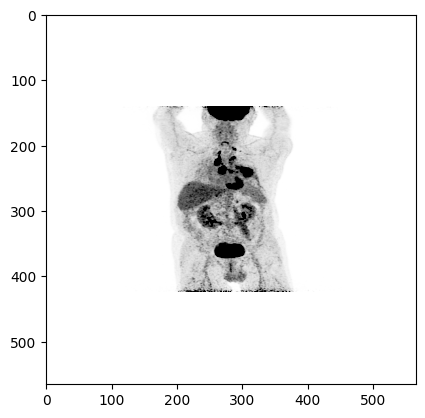

In [15]:
borne_max = None
is_mask = False
fig,ax=plt.subplots()
# ax.set_axis_off()
if borne_max is None:
    if is_mask==True:
        borne_max=1
    else:
        borne_max=suv_liver
plt.imshow(MIP,cmap='Greys',vmax=borne_max)
fig.savefig('MIP_test.png')


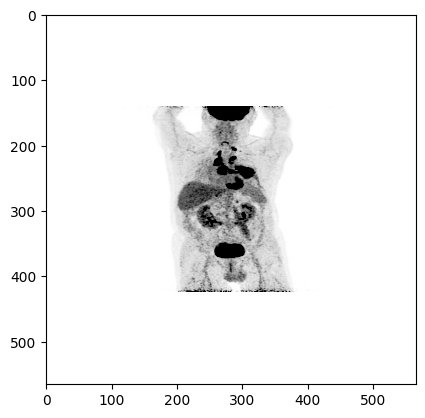

In [16]:
plt.imshow(annot+MIP,cmap='Greys',vmax=borne_max)

(480, 640, 4)


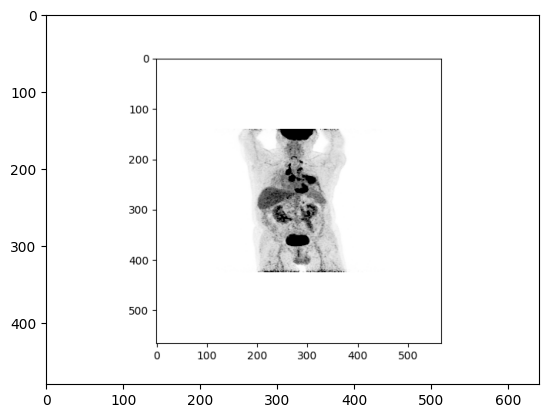

In [17]:
test = mpimg.imread('MIP_test.png')
print(test.shape)
imgplot = plt.imshow(test)
plt.show()

(566, 566, 3)
34.424618
0.0
(566, 566, 3, 4)
[[1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]]
(566, 566, 4)


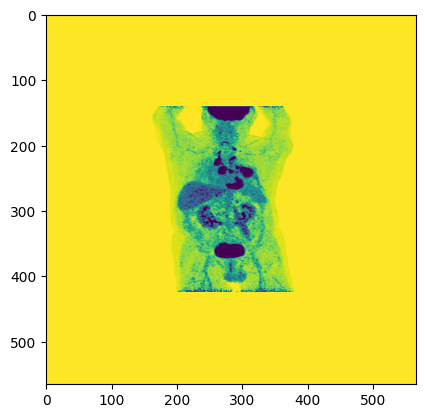

In [18]:
stacked = np.dstack([MIP]*3)
print(stacked.shape)
print(stacked.max())
print(stacked.min())
cmap = plt.cm.Greys
norm = plt.Normalize(vmin = 0, vmax = borne_max)
data = cmap(norm(stacked))
print(data.shape)

print(data[:,:,0][0][:4])
print(data[:,:,0].shape)
plt.imshow(data[:,:,0,1])

(566, 566, 4)
[1. 1. 1. 1.]
(566, 566, 3)


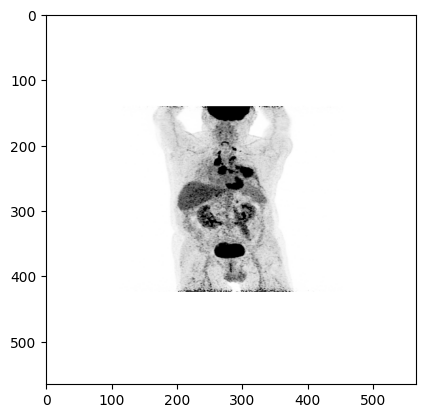

In [19]:
# Input for model

cmap = plt.cm.Greys
norm = plt.Normalize(vmin = 0, vmax = borne_max)

data = cmap(norm(MIP)) # already 3 channels
print(data.shape)


print(data[:,:,0][0][:4])
print(data[:,:,:3].shape)
plt.imshow(data[:,:,:3].copy())

(566, 566, 4)
[0.88575016 0.88575016 0.88575016 0.88575016]
(566, 566, 3)
float64


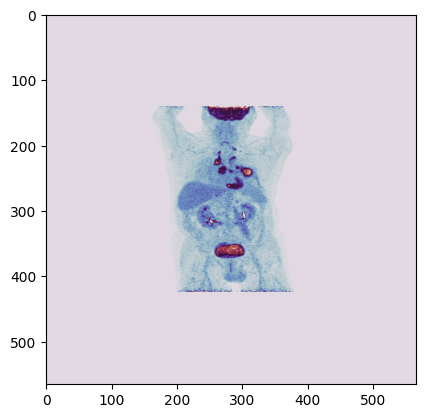

In [20]:
# Input for model

# cmap = plt.cm.twilight
cmap = plt.cm.get_cmap('twilight')
norm = plt.Normalize(vmin = 0, vmax = 10)


data = cmap(norm(MIP)) # already 3 channels
print(data.shape)


print(data[:,:,0][0][:4])
print(data[:,:,:3].shape)
print(np.dtype(data[:,:,0][0][0]))
plt.imshow(data[:,:,:3].copy())

(566, 566, 4)
[1. 1. 1. 1.]
(566, 566, 3)


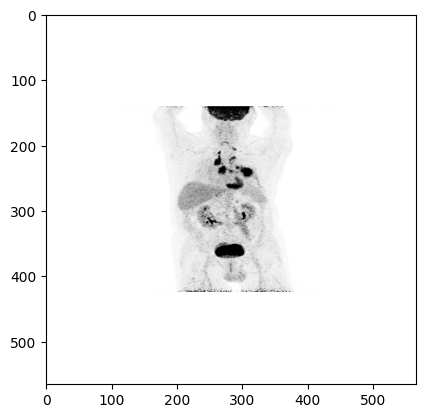

In [21]:
# Input for model

# cmap = plt.cm.Greys
cmap = plt.cm.get_cmap('Greys')
norm = plt.Normalize(vmin = 0, vmax = 5)

data = cmap(norm(MIP)) # already 3 channels
print(data.shape)


print(data[:,:,0][0][:4])
print(data[:,:,:3].shape)
plt.imshow(data[:,:,:3].copy())

In [22]:
print(MIP.shape, MIP[:4], MIP.min(), MIP.max())
print(test.shape, test[0][:4], test.min(), test.max())
print(data.shape, data[:,:,0][[0][:4]], data.min(),data.max())

(566, 566) [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]] 0.0 34.424618
(480, 640, 4) [[1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]] 0.0 1.0
(566, 566, 4) [[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.

In [23]:
# PIL_image = Image.open('MIP_test.png')

print(MIP.shape)
mip = cmap(norm(MIP)) # cmap inverts the pixels so it'll appear grey
print(mip.shape) # first 3 channels are just repeated gray image

PIL_image = Image.fromarray(np.uint8((mip[:,:,:3] * 255)))
print(type(PIL_image))
print(PIL_image.size) # width, height
num_channel = len(PIL_image.split())
print(num_channel)

PIL_image = PIL_image.convert('RGB')
print(PIL_image.size) 
num_channel = len(PIL_image.split())
print(num_channel)

PIL_image = Image.fromarray(np.uint8((MIP * 255)))
print(type(PIL_image))
print(PIL_image.size) # width, height
num_channel = len(PIL_image.split())
print(num_channel)
PIL_image = PIL_image.convert('RGB')
print(PIL_image.size) 
num_channel = len(PIL_image.split())
print(num_channel)

# PIL_image.show()
print(mip[:,:,0][0][:4])

(566, 566)
(566, 566, 4)
<class 'PIL.Image.Image'>
(566, 566)
3
(566, 566)
3
<class 'PIL.Image.Image'>
(566, 566)
1
(566, 566)
3
[1. 1. 1. 1.]


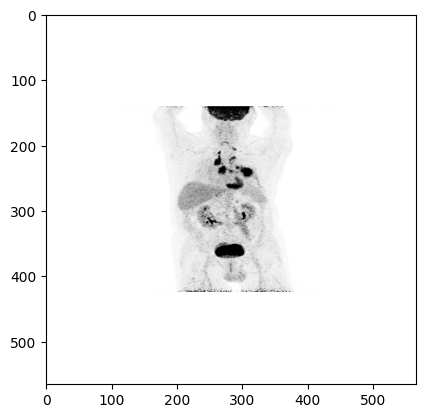

In [24]:
plt.imshow(mip[:,:,:3])

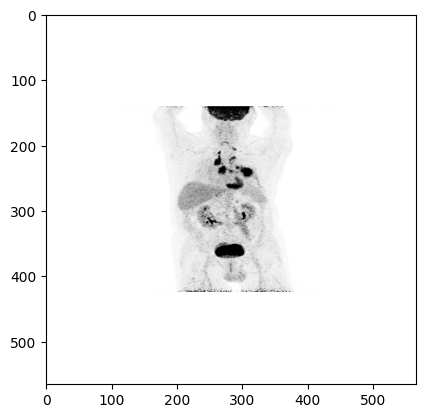

In [25]:
plt.imshow(mip)

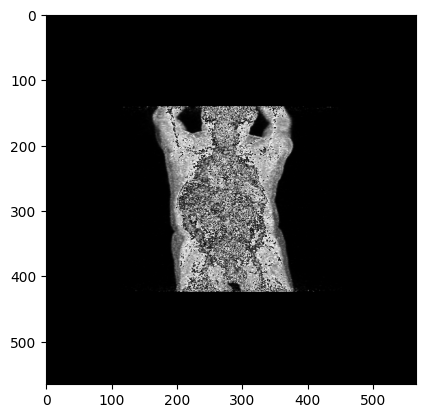

In [26]:
plt.imshow(PIL_image)

(566, 566, 4)
(566, 566, 3)


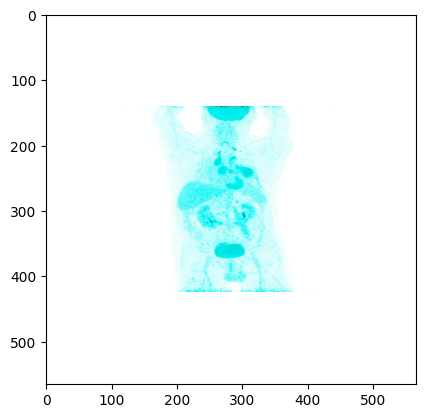

In [27]:
# Input for model

cmap = plt.cm.Greys
norm_liver = plt.Normalize(vmin = 0, vmax = suv_liver)
norm_brain = plt.Normalize(vmin = 0, vmax = suv_brain)
norm_max = plt.Normalize(vmin = 0, vmax = suv_max)

liver = cmap(norm_liver(MIP))
brain = cmap(norm_brain(MIP))
suvmax = cmap(norm_max(MIP))# already 3 channels
data = np.dstack([liver[:,:,0],brain[:,:,0],suvmax[:,:,0]])
print(liver.shape)
print(data.shape)

plt.imshow(data)

### Need to figure out the most equivalent in tenor as input for detr model
Input has to be a tensor with shape (C x H x W) and normalized in the range [0.0, 1.0]
So I can basically:
1. Read the .npy numpy array with SUV data
2. Normalize by SUV max from 5 to 10 to give enough contrast -- can be part of random select transform. numpy should already be between [0, 1] after this.
3. cmap to plt.cm.Greys 
4. Take just the first 3 channels after cmap. last channel alpha is just for transparency
5. Convert to a tensor with as_tensor() so can do transforms via pytorch on the GPU
6. May or may not need ToTensor()

### ToTensor()
Convert a PIL Image or numpy.ndarray to tensor. This transform does not support torchscript.
Converts a PIL Image or numpy.ndarray (H x W x C) in the range [0, 255] to a torch.FloatTensor of shape (C x H x W) 
in the range [0.0, 1.0] if the PIL Image belongs to one of the modes (L, LA, P, I, F, RGB, YCbCr, RGBA, CMYK, 1) 
or if the numpy.ndarray has dtype = np.uint8
In the other cases, tensors are returned without scaling.

### as_tensor()
Converts data into a tensor, sharing data and preserving autograd history if possible.
If data is already a tensor with the requested dtype and device then data itself is returned, but if data is a tensor with 
a different dtype or device then it’s copied as if using data.to(dtype=dtype, device=device).
If data is a NumPy array (an ndarray) with the same dtype and device then a tensor is constructed using torch.from_numpy().

### T.Normalize()
Normalize a tensor image with mean and standard deviation. This transform does not support PIL Image. 
Given mean: (mean[1],...,mean[n]) and std: (std[1],..,std[n]) for n channels, this transform will normalize each channel of the input torch.*Tensor i.e., output[channel] = (input[channel] - mean[channel]) / std[channel]

### Doing colormaps in tensors
color_map = #Tensor of shape(256,3)

gray_image = (gray_image * 255).long() # Tensor values between 0 and 255 and LongTensor and shape of (512,512)

output = color_map[gray_image]

In [28]:
import torch
import random

In [29]:
# path to
detr_root = '/gpfs/fs0/data/stanford_data/petct/DETR_MIP/FDG-PET-CT-Lesions/images/train/'
!ls $detr_root

0.npy	   15570.npy  21142.npy  26716.npy  32289.npy  37862.npy  4425.npy
1.npy	   15571.npy  21143.npy  26717.npy  3229.npy   37863.npy  4426.npy
10.npy	   15572.npy  21144.npy  26718.npy  32290.npy  37864.npy  4427.npy
100.npy    15573.npy  21145.npy  26719.npy  32291.npy  37865.npy  4428.npy
1000.npy   15574.npy  21146.npy  2672.npy   32292.npy  37866.npy  4429.npy
10000.npy  15575.npy  21147.npy  26720.npy  32293.npy  37867.npy  443.npy
10001.npy  15576.npy  21148.npy  26721.npy  32294.npy  37868.npy  4430.npy
10002.npy  15577.npy  21149.npy  26722.npy  32295.npy  37869.npy  4431.npy
10003.npy  15578.npy  2115.npy	 26723.npy  32296.npy  3787.npy   4432.npy
10004.npy  15579.npy  21150.npy  26724.npy  32297.npy  37870.npy  4433.npy
10005.npy  1558.npy   21151.npy  26725.npy  32298.npy  37871.npy  4434.npy
10006.npy  15580.npy  21152.npy  26726.npy  32299.npy  37872.npy  4435.npy
10007.npy  15581.npy  21153.npy  26727.npy  323.npy    37873.npy  4436.npy
10008.npy  15582.npy  21154.npy 

12604.npy  18178.npy  23750.npy  29323.npy  34897.npy  40469.npy  7032.npy
12605.npy  18179.npy  23751.npy  29324.npy  34898.npy  4047.npy   7033.npy
12606.npy  1818.npy   23752.npy  29325.npy  34899.npy  40470.npy  7034.npy
12607.npy  18180.npy  23753.npy  29326.npy  349.npy    40471.npy  7035.npy
12608.npy  18181.npy  23754.npy  29327.npy  3490.npy   40472.npy  7036.npy
12609.npy  18182.npy  23755.npy  29328.npy  34900.npy  40473.npy  7037.npy
1261.npy   18183.npy  23756.npy  29329.npy  34901.npy  40474.npy  7038.npy
12610.npy  18184.npy  23757.npy  2933.npy   34902.npy  40475.npy  7039.npy
12611.npy  18185.npy  23758.npy  29330.npy  34903.npy  40476.npy  704.npy
12612.npy  18186.npy  23759.npy  29331.npy  34904.npy  40477.npy  7040.npy
12613.npy  18187.npy  2376.npy	 29332.npy  34905.npy  40478.npy  7041.npy
12614.npy  18188.npy  23760.npy  29333.npy  34906.npy  40479.npy  7042.npy
12615.npy  18189.npy  23761.npy  29334.npy  34907.npy  4048.npy   7043.npy
12616.npy  1819.npy   23762

In [30]:
img_ann_path = os.path.join(detr_root, '0.npy')

with open(img_ann_path, 'rb') as f:
    suv_img = np.load(f) # this is a gray image... need to make into rgb and also want to augment for different SUV max
    masks = np.load(f)
    
print(np.dtype(suv_img[0,0]))

float64


1.0
0.0
(566, 566, 3)


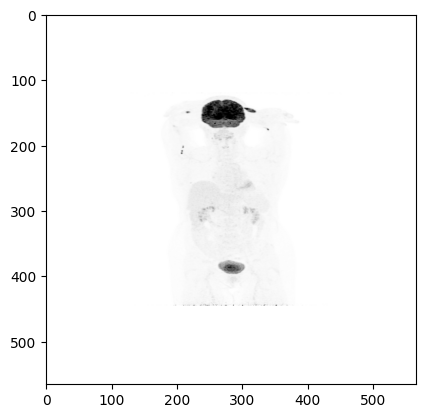

In [72]:
# Random cmap augmentation -- need to resave it!
colorlist = ['Greys']
color = random.choice(colorlist)
cmap = plt.cm.get_cmap(color)
# Randrom augmentation for SUV normalization
suv_values = [6,7,8,9,10, 15, 20]
suv_max = random.choice(suv_values)
norm = plt.Normalize(vmin = 0, vmax = 20)
img = cmap(norm(suv_img))[:,:,:3].copy().astype('float32')

print(img.max())
print(img.min())
print(img.shape)

plt.imshow(img)

In [32]:
import torch
import torch.utils.data
import torchvision
from pycocotools import mask as coco_mask

import datasets.transforms as T
import torchvision.transforms.functional as F


In [75]:
# So F.to_tensor (used by T.ToTensor in detr code, does switch array to channel first)
timg = F.to_tensor(img)
print(img.shape)
print(timg.shape)

(566, 566, 3)
torch.Size([3, 566, 566])


In [19]:
#https://github.com/InsightSoftwareConsortium/SimpleITK-Notebooks/blob/master/Python/21_Transforms_and_Resampling.ipynb

# interpolation options: 'antialiased', 'none', 'nearest', 'bilinear', 'bicubic', 'spline16', 'spline36', 'hanning', 'hamming', 'hermite', 'kaiser', 'quadric', 'catrom', 'gaussian', 'bessel', 'mitchell', 'sinc', 'lanczos', 'blackman'

# 8mm/2.03642 spacing = 3.92846269434 pixels/mm =~ 100dpi

def interpolate_show_MIP(i, nda, suv_max, spacing=(1,1), title=None, margin=0, dpi=100, colormap='Greys', OUTPATH=None,show=False):
    ysize = nda.shape[0]
    xsize = nda.shape[1]

    figsize = (1 + margin) * xsize * spacing[0] / dpi, (1 + margin) * ysize * spacing[1] / dpi

    fig = plt.figure(title, figsize=figsize, dpi=dpi)
    ax = fig.add_axes([margin, margin, 1 - 2 * margin, 1 - 2 * margin])
    #hide axis
    ax.axis('off')
    
    extent = (0, xsize * spacing[0], 0, ysize * spacing[1])

    #various papers mentions bicubic interpolation...
    t = ax.imshow(
#         nda, extent=extent, interpolation="hamming", cmap="Greys", origin="upper", vmax=suv_max
#         nda, extent=extent, interpolation="bilinear", cmap="Greys", origin="upper", vmax=suv_max
        nda, extent=extent, interpolation="bicubic", cmap=colormap, origin="upper", vmax=suv_max 
    )

    if title:
        plt.title(title)
    if OUTPATH != None:
        fig.savefig(os.path.join(OUTPATH,'MIP'+'%04d' % (i)+'.png'), dpi = dpi)
    if not show:
        plt.close(fig)
    
    # testing
    fig.savefig('MIPtest.png', dpi = dpi)

    
# Color map options:
# 'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 
# 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 
# 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 
# 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 
# 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 
# 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 
# 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 
# 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 
# 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'cubehelix', 'cubehelix_r', 
# 'flag', 'flag_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 
# 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 
# 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'inferno', 'inferno_r', 'jet', 
# 'jet_r', 'magma', 'magma_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 
# 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 
# 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'turbo', 'turbo_r', 
# 'twilight', 'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 'viridis', 'viridis_r', 'winter', 'winter_r'

In [20]:
w = img.header['pixdim'][1]
y = img.header['pixdim'][3]
spacing = (1, y/w)
print(spacing)

(1, 1.4731734)


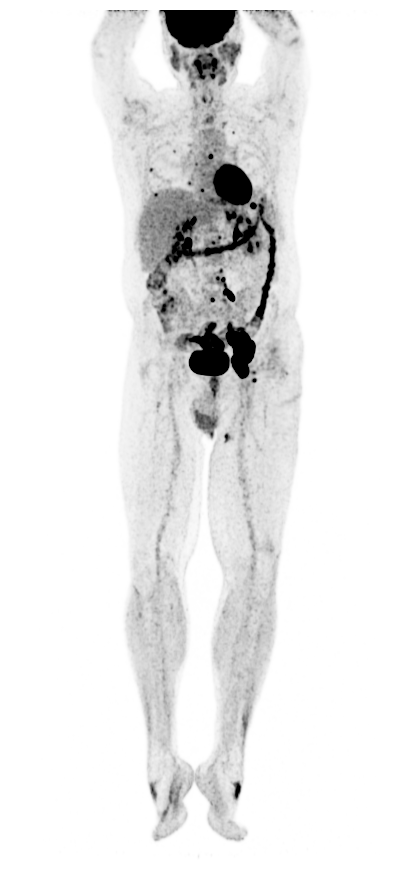

In [21]:
interpolate_show_MIP(0, MIP, borne_max, spacing=spacing,show=True)

#'greys' is not a valid value for name; supported values are 'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'turbo', 'turbo_r', 'twilight', 'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 'viridis', 'viridis_r', 'winter', 'winter_r'


(4.0, 8.5)


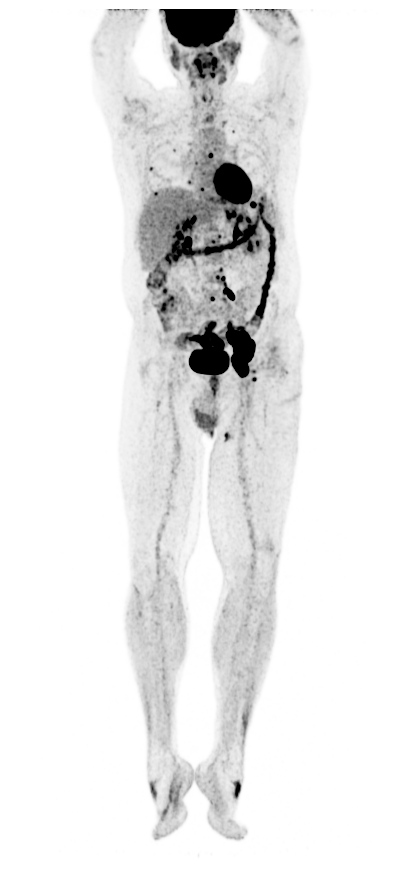

In [22]:
test = mpimg.imread('MIPtest.png')
# print(test.shape)
dpi=100
margin = 0
ysize = test.shape[0]
xsize = test.shape[1]
figsize =  xsize / dpi, ysize / dpi
print(figsize)
fig = plt.figure(figsize=figsize, dpi=dpi)
# hide axis
ax = fig.add_axes([margin, margin, 1 - 2 * margin, 1 - 2 * margin])
ax.axis('off')
plt.imshow(test)

In [17]:
# This generates MIP from axial nifti then saves each rotating frame as a .png then reads to to generate the GIF
# It is not very efficient for downstream
mip.create_mipGIF_from_3D(img,nb_image=48,duration=0.1,is_mask=False,borne_max=None)

Pixel spacing ratio: (1, 1.4731734)
Liver SUV max 5.02968882156372
Interpolating
angle: 0.0
angle: 7.659574468085107
angle: 15.319148936170214
angle: 22.97872340425532
angle: 30.638297872340427
angle: 38.297872340425535
angle: 45.95744680851064
angle: 53.61702127659575
angle: 61.276595744680854
angle: 68.93617021276596
angle: 76.59574468085107
angle: 84.25531914893618
angle: 91.91489361702128
angle: 99.57446808510639
angle: 107.2340425531915
angle: 114.8936170212766
angle: 122.55319148936171
angle: 130.2127659574468
angle: 137.87234042553192
angle: 145.53191489361703
angle: 153.19148936170214
angle: 160.85106382978725
angle: 168.51063829787236
angle: 176.17021276595744
angle: 183.82978723404256
angle: 191.48936170212767
angle: 199.14893617021278
angle: 206.8085106382979
angle: 214.468085106383
angle: 222.12765957446808
angle: 229.7872340425532
angle: 237.4468085106383
angle: 245.10638297872342
angle: 252.76595744680853
angle: 260.4255319148936
angle: 268.0851063829787
angle: 275.744680

In [23]:
def to_shape(a, shape):
    y_, x_ = shape
    y, x = a.shape
    y_pad = (y_-y)
    x_pad = (x_-x)
    return np.pad(a,((y_pad//2, y_pad//2 + y_pad%2), 
                     (x_pad//2, x_pad//2 + x_pad%2)),
                  mode = 'constant') #Default is 0

def create_mipNIFTI_from_3D(img, nb_image=48, OUTPATH=None):
    ls_mip=[]
    
    
    img_data=img.get_fdata()
    shape = img.get_fdata().shape
    max_dim = max(shape)
    diag = int(np.ceil(np.sqrt(np.square(shape[0])+np.square(shape[1]))))
    max_dim = max(max_dim, diag)
    target_shape = (max_dim,max_dim)
    
    #Modified nifti header saving useful axial slices information
    header=img.header.copy()
    # Can't seem to create new fields but can use existing fields to store other information...
    header = img.header.copy()
    liver_idx = img_data.shape[-1]//2
    suv_liver = img_data[:,:,liver_idx].squeeze().max()
    suv_brain = img_data[:,:,-1].squeeze().max()
    print('Liver SUV max', suv_liver)
    header['intent_p1'] = suv_liver
    header['intent_p2'] = suv_brain
    header['intent_p3'] = img_data.max()
    # Can't store too many letters...
    header['intent_name'] = b'liver;brain;max'
    
    print('Interpolating')
    img_data+=1e-5
    for angle in np.linspace(0,360,nb_image):
        ls_slice=[]
        # This step is slow: https://stackoverflow.com/questions/14163211/rotation-in-python-with-ndimage
#         vol_angle= scipy.ndimage.interpolation.rotate(img_data,angle,order=0)
        vol_angle = scipy.ndimage.rotate(img_data,angle,order=0)
        
        MIP=np.amax(vol_angle,axis=1)
        MIP-=1e-5
        MIP[MIP<1e-5]=0
        MIP=np.flipud(MIP.T)
        MIP=to_shape(MIP, target_shape)
        ls_mip.append(MIP)
        print('angle:', angle, MIP.shape)
    
    new_data = np.dstack(ls_mip) #shape [:,:,i]
    mip_nifti = nib.Nifti1Image(new_data, None, header)
    
    if OUTPATH != None:
        nib.save(mip_nifti, os.path.join(OUTPATH,'MIP.nii.gz'))
    
    return mip_nifti

In [24]:
# This generates MIP and saves/return as a NIFTI MIP which can be saved/read back as a single file for multiple downstream purposes
mip_nifti = create_mipNIFTI_from_3D(img,nb_image=4,OUTPATH='MIP')
# Pad constant width to max of x, y, z dimension before dstack the MIPs

Liver SUV max 5.02968882156372
Interpolating
angle: 0.0 (577, 577)
angle: 120.0 (577, 577)
angle: 240.0 (577, 577)
angle: 360.0 (577, 577)


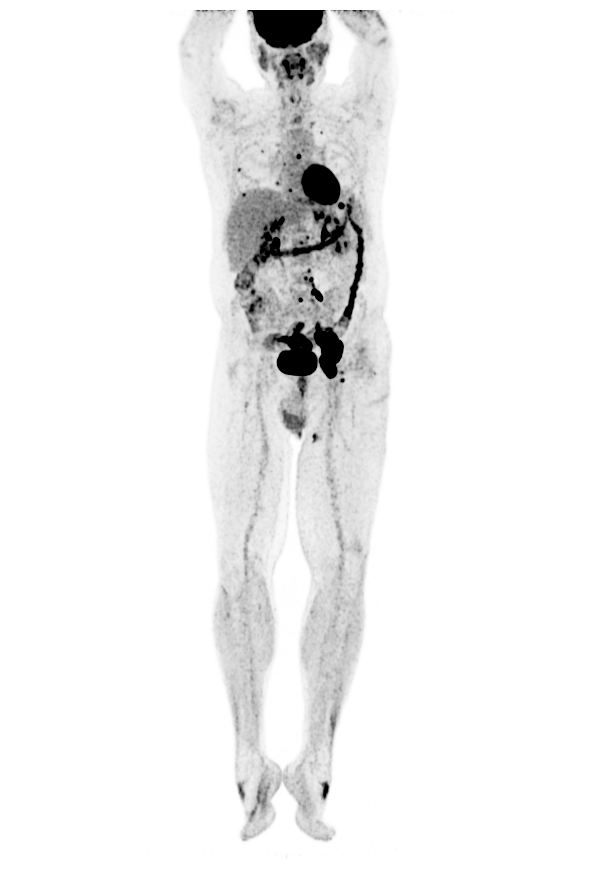

In [25]:
# Now can generate visualizable MIP from nifti SUV MIP data instead of reading back individual .pngs for each frame

mip_nifti = nib.load(os.path.join('MIP','MIP.nii.gz'))
frame = mip_nifti.get_fdata()[:,:,0]
# One downstream task, e.g. is to display an interpolated MIP image later
# This way, the contrast can be adjusted as needed
suv_max = borne_max
# suv_max = 30
interpolate_show_MIP(0, frame, suv_max, spacing=spacing,show=True)

In [26]:
# Now just need to process a MIP NIFTI for each study via:
# Documents/Gaze_PET-CT/utils/MIP-PET/GIF_mip.py

In [27]:
# For ground truth data need to get from segmentations

seg = nib.load(os.path.join(study_dirs[idx],'SEG.nii.gz'))

In [28]:
seg_mip = create_mipNIFTI_from_3D(seg,nb_image=4)

Liver SUV max 0.0
Interpolating
angle: 0.0 (577, 577)
angle: 120.0 (577, 577)
angle: 240.0 (577, 577)
angle: 360.0 (577, 577)


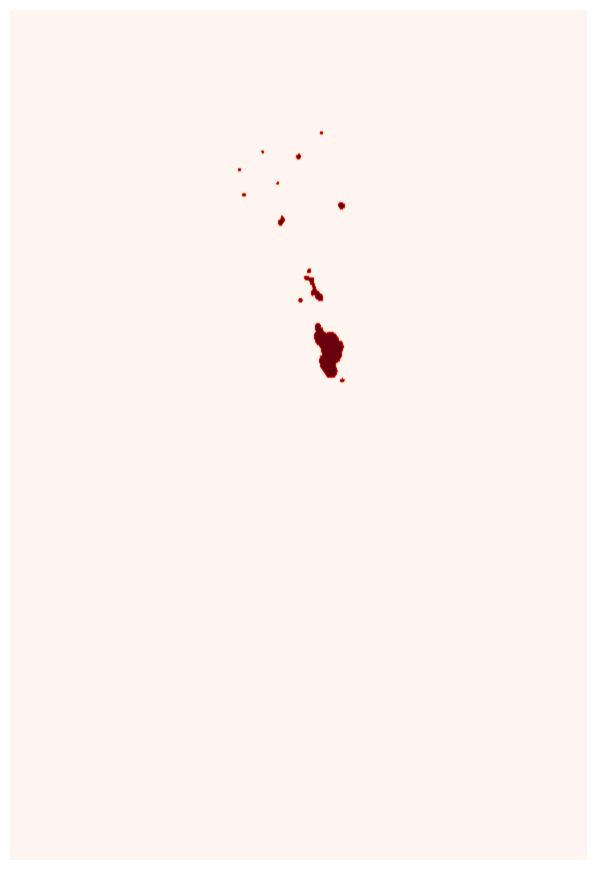

In [29]:
# Can generate bboxes for each tumoral lesion
frame = seg_mip.get_fdata()[:,:,0]
suv_max = 1
interpolate_show_MIP(0, frame, suv_max, spacing=spacing,show=True,colormap='Reds')

In [30]:
import cv2

In [31]:
print(frame.max())
print(frame.min())
print(type(frame))
print(frame.shape)


1.0
0.0
<class 'numpy.ndarray'>
(577, 577)


In [32]:
# Applying threshold
gray_img = frame.astype("uint8")
threshold = cv2.threshold(gray_img, 0, 1, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]


# Apply the Component analysis function
analysis = cv2.connectedComponentsWithStats(gray_img,4,cv2.CV_32S)
(totalLabels, label_ids, values, centroid) = analysis
print(totalLabels)
print(len(label_ids))
print(len(values))

14
577
14


In [33]:
#https://www.geeksforgeeks.org/python-opencv-connected-component-labeling-and-analysis/
masks = []

# Initialize a new image to
# store all the output components
output = np.zeros(gray_img.shape, dtype="uint8")

# Loop through each component
for i in range(1, totalLabels): # The first value is just the original image with all components
    area = values[i, cv2.CC_STAT_AREA]
    
    # Create a new image for bounding boxes
    new_img=gray_img.copy()

    # Now extract the coordinate points
    x1 = values[i, cv2.CC_STAT_LEFT]
    y1 = values[i, cv2.CC_STAT_TOP]
    w = values[i, cv2.CC_STAT_WIDTH]
    h = values[i, cv2.CC_STAT_HEIGHT]

    # Coordinate of the bounding box
    pt1 = (x1, y1)
    pt2 = (x1+ w, y1+ h)
    (X, Y) = centroid[i]

    # Create a new array to show individual component
    component = np.zeros(gray_img.shape, dtype="uint8")
    componentMask = (label_ids == i).astype("uint8") * 255

    # Apply the mask using the bitwise operator
    component = cv2.bitwise_or(component,componentMask)
    masks.append(component)
    output = cv2.bitwise_or(output, componentMask)

In [53]:
print(area)

10


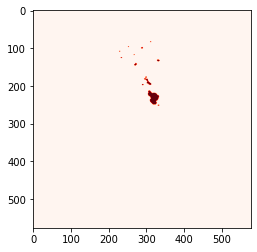

In [116]:
plt.imshow(gray_img, cmap='Reds') 

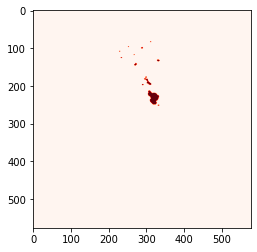

In [117]:
plt.imshow(output, cmap='Reds') 

13


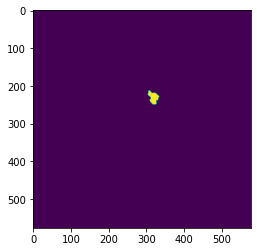

In [35]:
print(len(masks))
plt.imshow(masks[11]) 

In [54]:
print(masks[0].shape)
print(type(masks[0]))
annotations = np.dstack(masks).astype("uint8") # up to 225 which should be more than enough precision for SUV
print(annotations.shape)
print(annotations[:,:,0].shape)
print(frame.shape)


(577, 577)
<class 'numpy.ndarray'>
(577, 577, 13)
(577, 577)
(577, 577)


In [48]:
with open('test.npy', 'wb') as f:
    np.save(f, mip_nifti.get_fdata()[:,:,0])
    np.save(f, annotations)

In [49]:
with open('test.npy', 'rb') as f:
    a = np.load(f)
    b = np.load(f)
    
print(a.shape)
print(b.shape)

(577, 577)
(577, 577, 13)


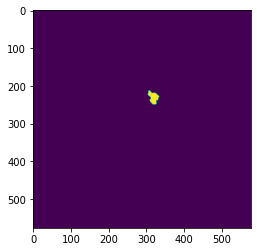

In [50]:
plt.imshow(b[:,:,11]) 

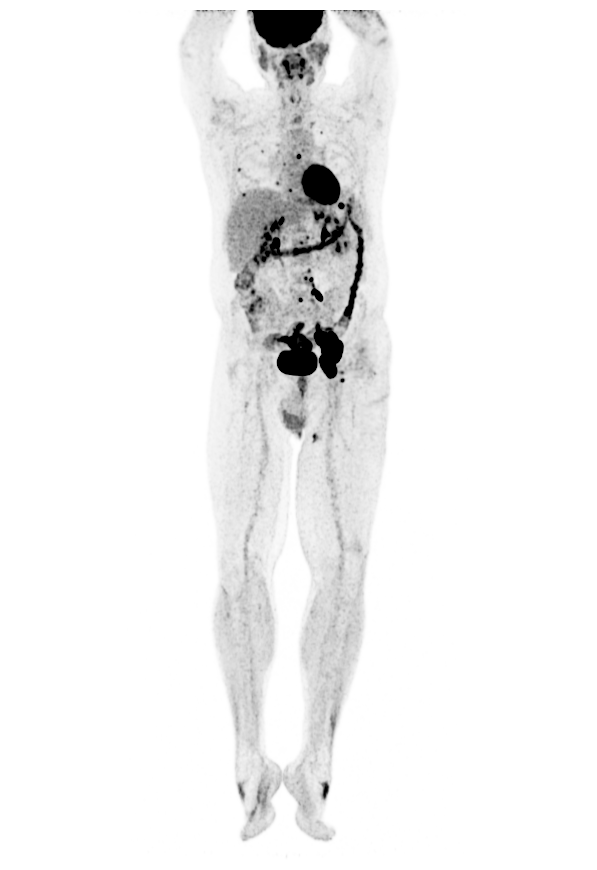

In [52]:
interpolate_show_MIP(0, a, 5.5, spacing=spacing,show=True)

In [114]:
#https://github.com/chrise96/image-to-coco-json-converter

In [147]:
from shapely.geometry import Polygon, MultiPolygon 
from skimage import measure 

In [165]:
def create_sub_masks(mask_image, width, height):
    # Initialize a dictionary of sub-masks indexed by RGB colors
    sub_masks = {}
    for x in range(width):
        for y in range(height):
            # Get the RGB values of the pixel
            pixel = mask_image.getpixel((x,y))[:3]

            # Check to see if we have created a sub-mask...
            pixel_str = str(pixel)
            sub_mask = sub_masks.get(pixel_str)
            if sub_mask is None:
               # Create a sub-mask (one bit per pixel) and add to the dictionary
                # Note: we add 1 pixel of padding in each direction
                # because the contours module doesn"t handle cases
                # where pixels bleed to the edge of the image
                sub_masks[pixel_str] = Image.new("1", (width+2, height+2))

            # Set the pixel value to 1 (default is 0), accounting for padding
            sub_masks[pixel_str].putpixel((x+1, y+1), 1)

    return sub_masks

def create_sub_mask_annotation(sub_mask):
    # Find contours (boundary lines) around each sub-mask
    # Note: there could be multiple contours if the object
    # is partially occluded. (E.g. an elephant behind a tree)
    contours = measure.find_contours(np.array(sub_mask), 0.5, positive_orientation="low")

    polygons = []
    segmentations = []
    for contour in contours:
        # Flip from (row, col) representation to (x, y)
        # and subtract the padding pixel
        for i in range(len(contour)):
            row, col = contour[i]
            contour[i] = (col - 1, row - 1)

        # Make a polygon and simplify it
        poly = Polygon(contour)
        poly = poly.simplify(1.0, preserve_topology=False)
        
        if(poly.is_empty):
            # Go to next iteration, dont save empty values in list
            continue

        polygons.append(poly)

        segmentation = np.array(poly.exterior.coords).ravel().tolist()
        segmentations.append(segmentation)
    
    return polygons, segmentations

In [166]:
contours = measure.find_contours(masks[11], 0.5, positive_orientation="low")

In [167]:
contour = contours[0]
contour

array([[249.99803922, 324.        ],
       [249.99803922, 323.        ],
       [249.99803922, 322.        ],
       [249.99803922, 321.        ],
       [249.99803922, 320.        ],
       [249.99803922, 319.        ],
       [249.99803922, 318.        ],
       [249.99803922, 317.        ],
       [249.        , 316.00196078],
       [248.99803922, 316.        ],
       [248.        , 315.00196078],
       [247.99803922, 315.        ],
       [247.        , 314.00196078],
       [246.99803922, 314.        ],
       [246.        , 313.00196078],
       [245.99803922, 313.        ],
       [245.        , 312.00196078],
       [244.99803922, 312.        ],
       [244.        , 311.00196078],
       [243.99803922, 311.        ],
       [243.        , 310.00196078],
       [242.99803922, 310.        ],
       [242.        , 309.00196078],
       [241.        , 309.00196078],
       [240.        , 309.00196078],
       [239.99803922, 309.        ],
       [239.        , 308.00196078],
 

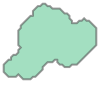

In [185]:
# Make a polygon and simplify it
poly = Polygon(contour)
# poly = poly.simplify(1.0, preserve_topology=False)
poly

In [169]:
segmentation = np.array(poly.exterior.coords).ravel().tolist()
segmentation

[249.99803921568628,
 324.0,
 249.99803921568628,
 323.0,
 249.99803921568628,
 322.0,
 249.99803921568628,
 321.0,
 249.99803921568628,
 320.0,
 249.99803921568628,
 319.0,
 249.99803921568628,
 318.0,
 249.99803921568628,
 317.0,
 249.0,
 316.0019607843137,
 248.99803921568628,
 316.0,
 248.0,
 315.0019607843137,
 247.99803921568628,
 315.0,
 247.0,
 314.0019607843137,
 246.99803921568628,
 314.0,
 246.0,
 313.0019607843137,
 245.99803921568628,
 313.0,
 245.0,
 312.0019607843137,
 244.99803921568628,
 312.0,
 244.0,
 311.0019607843137,
 243.99803921568628,
 311.0,
 243.0,
 310.0019607843137,
 242.99803921568628,
 310.0,
 242.0,
 309.0019607843137,
 241.0,
 309.0019607843137,
 240.0,
 309.0019607843137,
 239.99803921568628,
 309.0,
 239.0,
 308.0019607843137,
 238.0,
 308.0019607843137,
 237.0,
 308.0019607843137,
 236.00196078431372,
 309.0,
 236.0,
 309.0019607843137,
 235.0,
 309.0019607843137,
 234.00196078431372,
 310.0,
 234.00196078431372,
 311.0,
 234.0,
 311.0019607843137,
 

In [170]:
# https://github.com/open-mmlab/mmdetection/issues/7816
# bitmat segmentation representation not very accurate when decoded which may affect this dataset
# directly encode the mask into RLE format which should be more accurate.

## very useful## https://stackoverflow.com/questions/49494337/encode-numpy-array-using-uncompressed-rle-for-coco-dataset

In [177]:
import numpy as np
from itertools import groupby

def binary_mask_to_rle(binary_mask):
    rle = {'counts': [], 'size': list(binary_mask.shape)}
    counts = rle.get('counts')
    for i, (value, elements) in enumerate(groupby(binary_mask.ravel(order='F'))):
        if i == 0 and value == 1:
            counts.append(0)
        counts.append(len(list(elements)))
    return rle


def binary_mask_to_rle(binary_mask):
    rle = {'counts': [], 'size': list(binary_mask.shape)}
    counts = rle.get('counts')

    last_elem = 0
    running_length = 0

    for i, elem in enumerate(binary_mask.ravel(order='F')):
        if elem == last_elem:
            pass
        else:
            counts.append(running_length)
            running_length = 0
            last_elem = elem
        running_length += 1

    counts.append(running_length)

    return rle

In [178]:
test_list_1 = np.array([0, 0, 1, 1, 1, 0, 1])
test_list_2 = np.array([1, 1, 1, 1, 1, 1, 0])

print(binary_mask_to_rle(test_list_1))
print(binary_mask_to_rle(test_list_2))

{'counts': [2, 3, 1, 1], 'size': [7]}
{'counts': [0, 6, 1], 'size': [7]}


In [179]:
import json
import numpy as np
from pycocotools import mask
from skimage import measure

ground_truth_binary_mask = np.array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
                                     [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
                                     [  0,   0,   0,   0,   0,   1,   1,   1,   0,   0],
                                     [  0,   0,   0,   0,   0,   1,   1,   1,   0,   0],
                                     [  0,   0,   0,   0,   0,   1,   1,   1,   0,   0],
                                     [  0,   0,   0,   0,   0,   1,   1,   1,   0,   0],
                                     [  1,   0,   0,   0,   0,   0,   0,   0,   0,   0],
                                     [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
                                     [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0]], dtype=np.uint8)

fortran_ground_truth_binary_mask = np.asfortranarray(ground_truth_binary_mask)

In [180]:
rle = binary_mask_to_rle(fortran_ground_truth_binary_mask)
print(rle)

{'counts': [6, 1, 40, 4, 5, 4, 5, 4, 21], 'size': [9, 10]}


In [181]:
compressed_rle = mask.frPyObjects(rle, rle.get('size')[0], rle.get('size')[1])
mask.decode(compressed_rle)

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 1, 1, 0, 0],
       [0, 0, 0, 0, 0, 1, 1, 1, 0, 0],
       [0, 0, 0, 0, 0, 1, 1, 1, 0, 0],
       [0, 0, 0, 0, 0, 1, 1, 1, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=uint8)

In [182]:
fortran_ground_truth_binary_mask = np.asfortranarray(masks[11])
rle = binary_mask_to_rle(fortran_ground_truth_binary_mask)
print(rle)

{'counts': [175628, 4, 567, 4, 1, 7, 564, 14, 563, 15, 562, 15, 562, 16, 8, 3, 551, 16, 5, 8, 550, 17, 2, 9, 549, 29, 550, 28, 550, 28, 549, 29, 549, 29, 547, 31, 546, 31, 546, 31, 546, 31, 546, 31, 546, 31, 546, 31, 547, 30, 547, 29, 549, 19, 3, 5, 551, 18, 5, 1, 554, 16, 563, 14, 563, 12, 565, 11, 567, 6, 573, 2, 140558], 'size': [577, 577]}


In [183]:
compressed_rle = mask.frPyObjects(rle, rle.get('size')[0], rle.get('size')[1])
mask.decode(compressed_rle)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

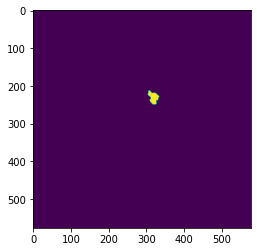

In [184]:
plt.imshow(mask.decode(compressed_rle)) 

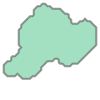

In [186]:
contours = measure.find_contours(mask.decode(compressed_rle), 0.5, positive_orientation="low")
contour = contours[0]
# Make a polygon and simplify it
poly = Polygon(contour)
# poly = poly.simplify(1.0, preserve_topology=False)
poly

In [268]:
def read_nii(nii_fname, study_path):
    img = nib.load(os.path.join(study_path, nii_fname))
    data = img.get_fdata()
    header = img.header
    return data, header


def interpolate_show_MIP(i, nda, suv_max, spacing=(1,1), title=None, margin=0, dpi=100, colormap='Greys', OUTPATH=None,show=False):
    ysize = nda.shape[0]
    xsize = nda.shape[1]

    figsize = (1 + margin) * xsize * spacing[0] / dpi, (1 + margin) * ysize * spacing[1] / dpi

    fig = plt.figure(title, figsize=figsize, dpi=dpi)
    ax = fig.add_axes([margin, margin, 1 - 2 * margin, 1 - 2 * margin])
    #hide axis
    ax.axis('off')
    
    extent = (0, xsize * spacing[0], 0, ysize * spacing[1])

    #various papers mentions bicubic interpolation...
    t = ax.imshow(
#         nda, extent=extent, interpolation="hamming", cmap="Greys", origin="upper", vmax=suv_max
#         nda, extent=extent, interpolation="bilinear", cmap="Greys", origin="upper", vmax=suv_max
        nda, extent=extent, interpolation="bicubic", cmap=colormap, origin="upper", vmax=suv_max 
    )

    if title:
        plt.title(title)
    if OUTPATH != None:
        fig.savefig(os.path.join(OUTPATH,'%04d' % (i)+'.png'), dpi = dpi)
    if not show:
        plt.close(fig)
    
    
def get_connected_componets_per_frame(frame):
    #https://www.geeksforgeeks.org/python-opencv-connected-component-labeling-and-analysis/
    masks = []
    areas = []
    bboxes = []
    centroids = []

    # Initialize a new image to
    # store all the output components
    output = np.zeros(gray_img.shape, dtype="uint8")
    
    # Some images are negative - normal negative no objects frames
    gray_img = frame.astype("uint8")
    
    if gray_img.max() > 0:
        # Applying threshold
        threshold = cv2.threshold(gray_img, 0, 1, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]

        # Apply the Component analysis function
        analysis = cv2.connectedComponentsWithStats(gray_img,4,cv2.CV_32S)
        (totalLabels, label_ids, values, centroids) = analysis
        
        # The first element is for the original frame
        centroids = centroids[1:]

        # Loop through each component
        for i in range(1, totalLabels): # The first value is just the original image with all components
            area = values[i, cv2.CC_STAT_AREA]
            areas.append(area)

    #         # Create a new image for bounding boxes
    #         new_img=gray_img.copy()

            # Now extract the coordinate points
            x1 = values[i, cv2.CC_STAT_LEFT]
            y1 = values[i, cv2.CC_STAT_TOP]
            w = values[i, cv2.CC_STAT_WIDTH]
            h = values[i, cv2.CC_STAT_HEIGHT]
            bbox = (x1, y1, w, h)
            bboxes.append(bbox)

    #         # Coordinate of the bounding box
    #         pt1 = (x1, y1)
    #         pt2 = (x1+ w, y1+ h)
    #         (X, Y) = centroid[i]

            # Create a new array to show individual component
            component = np.zeros(gray_img.shape, dtype="uint8")
            componentMask = (label_ids == i).astype("uint8") * 255

            # Apply the mask using the bitwise operator
            component = cv2.bitwise_or(component,componentMask)
            masks.append(component)
            output = cv2.bitwise_or(output, componentMask)
    
    return masks, areas, bboxes, centroids, output

    
def binary_mask_to_rle(binary_mask):
    fortran_ground_truth_binary_mask = np.asfortranarray(binary_mask)
    rle = {'counts': [], 'size': list(fortran_ground_truth_binary_mask.shape)}
    counts = rle.get('counts')

    last_elem = 0
    running_length = 0

    for i, elem in enumerate(binary_mask.ravel(order='F')):
        if elem == last_elem:
            pass
        else:
            counts.append(running_length)
            running_length = 0
            last_elem = elem
        running_length += 1

    counts.append(running_length)

    return rle


# Get all the segmentation from each frame/slice of a nifti
def get_annotations_per_frame(frame_idx, frame, image_id, category_id, annotation_id):
    
    masks, areas, bboxes, centroids, output = get_connected_componets_per_frame(frame)
    
    annotations = []
    for i, (binary_mask, area, bbox, centroid) in enumerate(zip(masks, areas, bboxes, centroids)):
        rle_seg = binary_mask_to_rle(binary_mask)
        frame_id = str(image_id) + '_' + str(frame_idx)
        annotation_id = str(annotation_id) + '_' + str(i) 
        annotation = create_annotation_format(rle_seg, area, frame_id, bbox, category_id, annotation_id)
        annotations.append(annotation)
    
    return annotations, annotation_id


def get_annotations_per_nifti(nii_fname, study_path, num_frames, category_id, annotation_id, annotations = []):
    data, header = read_nii(nii_fname, study_path)
    study_path = plb.Path(study_path)
    image_id = os.path.join(study_path.parent.name,study_path.name)
    
    if num_frames > data.shape[-1]:
        raise Exception("Number of frames exceeded number of nifti slices")
    else:
        # Evenly sample num_frames from nifty volume
        sampled_frames = np.linspace(0, data.shape[-1] - 1, num_frames).astype(int)
        # Get annotations for each frame
        for frame_idx in sampled_frames:
            frame = data[:,:,frame_idx]
            frame_annotations, annotation_id = get_annotations_per_frame(frame_idx, frame
                                                                         , image_id, category_id, annotation_id)
            annotations.extend(frame_annotations)
        
    return annotations, annotation_id


###

def create_category_annotation(category_dict):
    category_list = []

    for key, value in category_dict.items():
        category = {
            "supercategory": key,
            "id": value,
            "name": key
        }
        category_list.append(category)

    return category_list

def create_image_annotation(file_name, width, height, image_id):
    images = {
        "file_name": file_name,
        "height": height,
        "width": width,
        "id": image_id
    }

    return images

def create_annotation_format(rle_seg, area, frame_id, bbox, category_id, annotation_id):
    # COCO format for a RLE segmentation annotation
    annotation = {
        "segmentation": rle_seg,
        "area": area,
        "iscrowd": 0,
        "image_id": frame_id, #image_id,
        "bbox": bbox,
        "category_id": category_id,
        "id": annotation_id
    }
    
    return annotation

def get_coco_json_format():
    # Standard COCO format 
    coco_format = {
        "info": {},
        "licenses": [],
        "images": [{}],
        "categories": [{}],
        "annotations": [{}]
    }

    return coco_format


    

In [215]:
# negative cases

mip_root = '/media/storage/Joy/datasets/NIFTI_MIP/FDG-PET-CT-Lesions/'

tab = pd.read_csv("../../dataset/Clinical_Metadata_FDG_PET_CT_Lesions.csv")

In [228]:
negpaths = tab[tab['diagnosis'] == 'NEGATIVE']['File Location'].tolist()
negpaths = sorted(list(set(['/'.join(p.split('/')[2:-1]) for p in negpaths])))
print(len(negpaths))
print(negpaths[0])

513
PETCT_0143bab87a/07-17-2005-NA-PET-CT Ganzkoerper  primaer mit KM-33529


In [229]:
for neg in negpaths:
    negpath = os.path.join(mip_root,neg)
    if os.path.isdir(negpath):
        print(negpath)
        break

/media/storage/Joy/datasets/NIFTI_MIP/FDG-PET-CT-Lesions/PETCT_0143bab87a/07-17-2005-NA-PET-CT Ganzkoerper  primaer mit KM-33529


In [275]:
suvmip = nib.load(os.path.join(negpath,'SUV_MIP.nii.gz'))
segmip = nib.load(os.path.join(negpath,'SEG_MIP.nii.gz'))

45.38843536376953


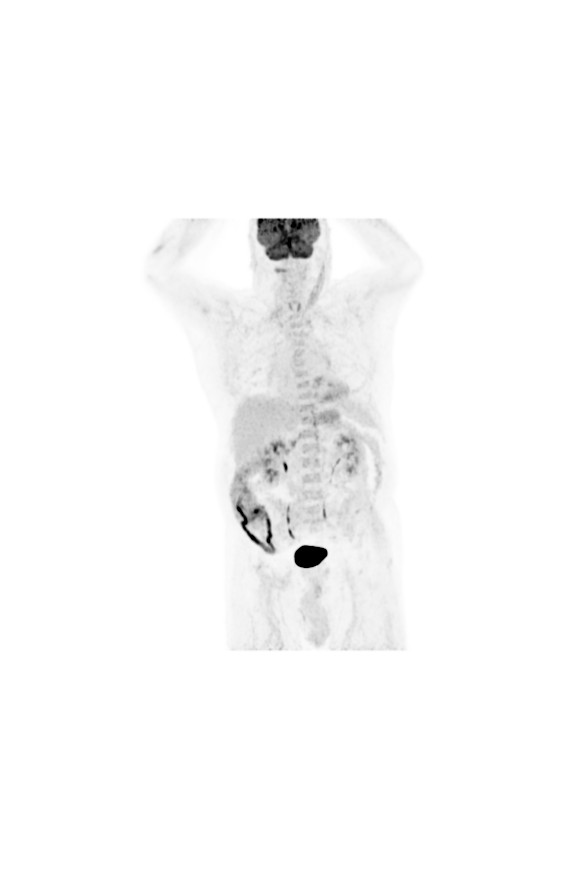

In [276]:
img_data = suvmip.get_fdata()
frame = img_data[:,:,0]
liver_idx = img_data.shape[-1]//2
suv_liver = img_data[:,:,liver_idx].squeeze().max()
print(suv_liver)
# suv_max = suv_liver
spacing = (1, 1.5)
interpolate_show_MIP(0, frame, 10, spacing=spacing,show=True)

In [286]:
header = suvmip.header
print(header['intent_p1'])
print(header)

4.5261497
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b''
dim_info        : 0
dim             : [  3 566 566  48   1   1   1   1]
intent_p1       : 4.5261497
intent_p2       : 12.272846
intent_p3       : 45.388435
intent_code     : none
datatype        : float32
bitpix          : 32
slice_start     : 0
pixdim          : [-1.       2.03642  2.03642  3.       1.       1.       1.       1.     ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 0
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b''
aux_file        : b''
qform_code      : unknown
sform_code      : aligned
quatern_b       : 0.0
quatern_c       : 1.0
quatern_d       : 0.0
qoffset_x       : 406.694
qoffset_y       : -

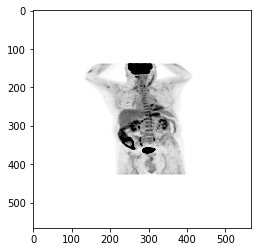

In [287]:
plt.imshow(frame,cmap='Greys',vmax=header['intent_p1'])

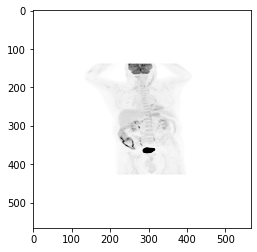

In [288]:
plt.imshow(frame,cmap='Greys',vmax=header['intent_p2'])

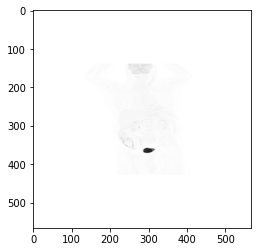

In [289]:
plt.imshow(frame,cmap='Greys',vmax=header['intent_p3'])

In [245]:
seg_data = segmip.get_fdata()
print(seg_data.shape)
segframe = seg_data[:,:,0]

(566, 566, 48)


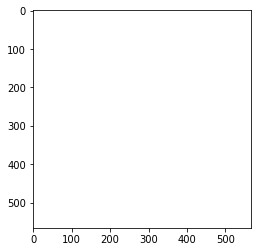

In [244]:
plt.imshow(segframe,cmap='Greys',vmax=1)

In [247]:
negrle = binary_mask_to_rle(segframe)
negrle

{'counts': [320356], 'size': [566, 566]}

In [249]:
segframe.max()

0.0

In [252]:
from pycocotools import mask as M
def decode_rle(rle):
    compressed_rle = M.frPyObjects(rle, rle.get('size')[0], rle.get('size')[1])
    binary_mask = M.decode(compressed_rle)
    return binary_mask

In [253]:
decodeneg = decode_rle(negrle)

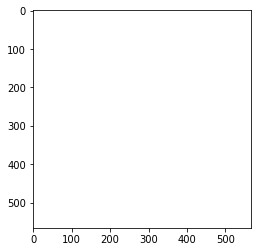

In [255]:
plt.imshow(decodeneg,cmap='Greys',vmax=1)

In [269]:
masks, areas, bboxes, centroid, output = get_connected_componets_per_frame(frame)

In [270]:
print(areas)

[1043, 41539, 38, 20, 21]


In [271]:
bboxes

[(141, 139, 64, 35),
 (137, 139, 270, 288),
 (231, 353, 11, 8),
 (323, 358, 10, 4),
 (228, 372, 8, 8)]

In [273]:
study_dirs = find_studies(mip_root)

print(len(study_dirs))
print(study_dirs[0])
print(study_dirs[0].parent.name)
print(study_dirs[0].name)

764
/media/storage/Joy/datasets/NIFTI_MIP/FDG-PET-CT-Lesions/PETCT_a61d8768d0/03-26-2004-NA-PET-CT Ganzkoerper  primaer mit KM-57711
PETCT_a61d8768d0
03-26-2004-NA-PET-CT Ganzkoerper  primaer mit KM-57711


In [274]:
type(masks[0])

numpy.ndarray

In [4]:
x = '/media/storage/Joy/datasets/DETR_MIP/FDG-PET-CT-Lesions/images/train/'
!ls $x

0.npy	  1135.npy  190.npy  325.npy  460.npy  596.npy	730.npy  866.npy
1000.npy  1136.npy  191.npy  326.npy  461.npy  597.npy	731.npy  867.npy
1001.npy  1137.npy  192.npy  327.npy  462.npy  598.npy	732.npy  868.npy
1002.npy  1138.npy  193.npy  328.npy  463.npy  599.npy	733.npy  869.npy
1003.npy  1139.npy  194.npy  329.npy  464.npy  59.npy	734.npy  86.npy
1004.npy  113.npy   195.npy  32.npy   465.npy  5.npy	735.npy  870.npy
1005.npy  1140.npy  196.npy  330.npy  466.npy  600.npy	736.npy  871.npy
1006.npy  1141.npy  197.npy  331.npy  467.npy  601.npy	737.npy  872.npy
1007.npy  1142.npy  198.npy  332.npy  468.npy  602.npy	738.npy  873.npy
1008.npy  1143.npy  199.npy  333.npy  469.npy  603.npy	739.npy  874.npy
1009.npy  1144.npy  19.npy   334.npy  46.npy   604.npy	73.npy	 875.npy
100.npy   1145.npy  1.npy    335.npy  470.npy  605.npy	740.npy  876.npy
1010.npy  1146.npy  200.npy  336.npy  471.npy  606.npy	741.npy  877.npy
1011.npy  1147.npy  201.npy  337.npy  472.npy  607.npy	742.npy  878.npy

In [9]:
with open(os.path.join(x,'0.npy'), 'rb') as f:
    a = np.load(f)
    b = np.load(f)
    
print(a.shape)
print(b.shape)

(566, 566)
(566, 566, 5)


In [8]:
import base64